In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnam-video-frames-traffic-sign/split/data.yaml
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_490.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_358.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_230.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_112.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_430.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_500.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_128.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_332.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_420.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_304.txt
/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels/image_508.txt
/kaggle/input/vietnam-video-frames-traffic-si

# Import and set up

In [2]:
# Install Ultralytics library
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 602.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [3]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import squarify
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video
import random

# Setting path

In [4]:
train_imgs = "/kaggle/input/vietnam-video-frames-traffic-sign/split/train/images"
train_labels = "/kaggle/input/vietnam-video-frames-traffic-sign/split/train/labels"

In [5]:
test_imgs = "/kaggle/input/vietnam-video-frames-traffic-sign/split/test/images"
test_labels = "/kaggle/input/vietnam-video-frames-traffic-sign/split/test/labels"

In [6]:
valid_imgs = "/kaggle/input/vietnam-video-frames-traffic-sign/split/valid/images"
valid_labels = "/kaggle/input/vietnam-video-frames-traffic-sign/split/labels/images"

In [7]:
data_yml = "/kaggle/input/vietnam-video-frames-traffic-sign/split/data.yaml"

# Visualization

In [8]:
def get_random_imgs(num_imgs, folder_path):
    """
    Get the random images from a specific folder path image
    
    Args:
        num_imgs: number of random images want to get
        folder_path: path to folder image of train, test, or valid dataset
    
    Returns:
        A list of elements chosen from the sequence
    """
    files = os.listdir(folder_path)
    random_imgs = random.sample(files, num_imgs)
    return random_imgs

In [9]:
def get_row_col(num_imgs):
    """
    Get row and col to visualize
    
    Args:
        num_imgs: the number of imgs want to visualize
    Returns:
        The integer value of row and col
    """
    if num_imgs <= 0:
        return None
    rows = int(num_imgs**0.5)
    cols = int(num_imgs**0.5)
    return rows, cols

In [10]:
# get random 9 imgs from train folder
random_imgs = get_random_imgs(9, train_imgs)


# get the rows and cols to plots
rows, cols = get_row_col(len(random_imgs))

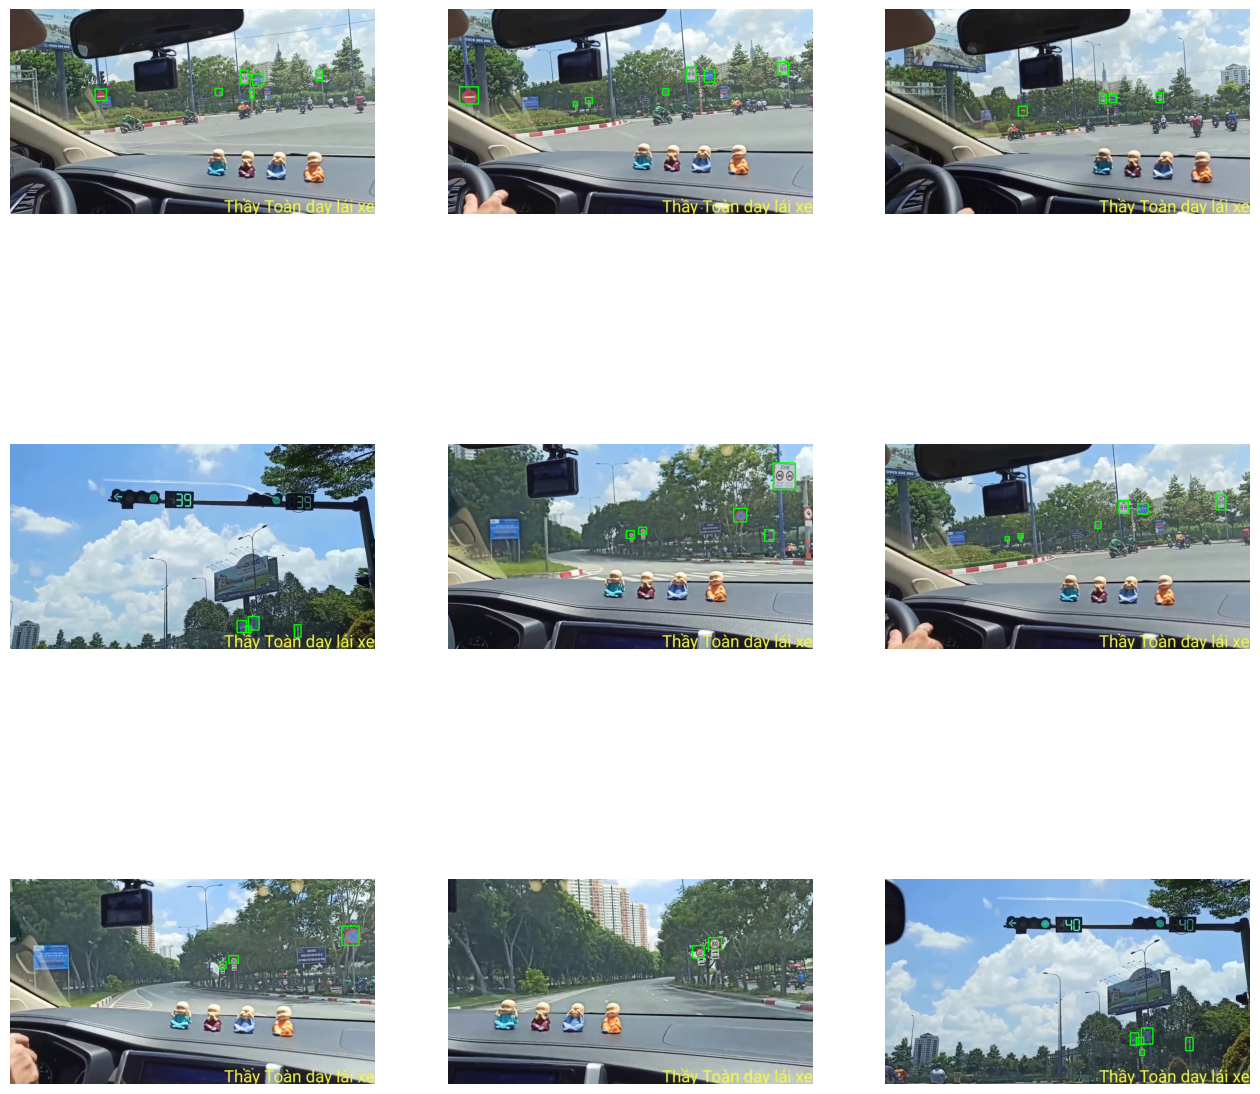

In [11]:
# Set up the plot
fig, axs = plt.subplots(rows,cols, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, img_file in enumerate(random_imgs):
    row = i // cols
    col = i % cols
    # Load the image
    img_path = os.path.join(train_imgs, img_file)
    img = cv2.imread(img_path)

    # Load the labels for this image
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * img.shape[1])
        y_min = int((y_center - height/2) * img.shape[0])
        x_max = int((x_center + width/2) * img.shape[1])
        y_max = int((y_center + height/2) * img.shape[0])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Get Metadata

In [12]:
img_path = "/kaggle/input/vietnam-video-frames-traffic-sign/split/test/images/image_108.jpg"

image = cv2.imread(img_path)

In [13]:
#Get size of image
height, width, channels = image.shape
print(f'{height}*{width}*{channels}')

720*1280*3


# Training Model

In [14]:
# Load pre-trained model
yolov8 = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 278MB/s]  


In [16]:
yolov8.train(data = data_yml,
            epochs = 64,
            imgsz = height,
            seed = 42,
            batch = 8,
            workers = 4)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/input/vietnam-video-frames-traffic-sign/split/data.yaml, epochs=64, time=None, patience=100, batch=8, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 71.6MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]


train: Scanning /kaggle/input/vietnam-video-frames-traffic-sign/split/train/labels... 200 images, 8 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 132.89it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/vietnam-video-frames-traffic-sign/split/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/vietnam-video-frames-traffic-sign/split/valid/labels... 44 images, 1 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 110.52it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/vietnam-video-frames-traffic-sign/split/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 64 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/64      9.84G      2.472      5.894       1.24         29        736:   8%|▊         | 2/25 [00:03<00:32,  1.41s/it]

       1/64      9.84G      2.361      5.903      1.188         48        736:  12%|█▏        | 3/25 [00:03<00:24,  1.13s/it]
100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]
       1/64      9.91G      1.975      3.768      1.095         23        736: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         44        168       0.54        0.6      0.602      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/64      9.62G      1.701      1.674      1.009         32        736: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         44        168      0.676      0.634      0.677      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/64      9.59G       1.58      1.377     0.9887         22        736: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         44        168      0.694      0.682      0.712      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/64      9.58G      1.607      1.286     0.9938         61        736: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         44        168      0.538      0.704      0.595      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/64      9.58G       1.54      1.101     0.9872         70        736: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         44        168      0.614      0.695      0.703      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/64      9.59G      1.601      1.051     0.9793         63        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.711       0.69      0.723      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/64      9.56G      1.542     0.9306     0.9851         62        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         44        168      0.714      0.722        0.7      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/64      9.59G      1.516     0.8657     0.9749         51        736: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.719      0.712      0.721      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/64      9.58G      1.482     0.7917      0.969         62        736: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168       0.71      0.703      0.709      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/64      9.58G      1.468     0.7754     0.9831         31        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         44        168      0.716      0.722      0.723      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/64      9.55G      1.419       0.71     0.9518         50        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.712      0.711      0.711      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/64      9.57G      1.399     0.6798     0.9386         62        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.752      0.734      0.727      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/64      9.57G      1.424     0.6931     0.9546         55        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.718      0.728      0.718      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/64      9.57G      1.413     0.7175      0.933         91        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.707      0.682      0.693      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/64      9.57G      1.392     0.6843     0.9365         54        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.723      0.705      0.704      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/64      9.57G      1.402     0.6489     0.9403         27        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.724      0.712      0.723      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/64      9.59G      1.333     0.6145     0.9272         59        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         44        168      0.721      0.702      0.715      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/64      9.55G      1.372     0.6478     0.9272         57        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         44        168      0.701      0.703      0.712       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/64      9.56G      1.351     0.6287     0.9267         31        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.714        0.7      0.719      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/64      9.58G      1.338     0.6431     0.9327         52        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.713      0.725      0.719      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/64      9.59G       1.36     0.6232     0.9255         65        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         44        168       0.73      0.713      0.718      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/64      9.58G      1.302     0.6189     0.9247         25        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         44        168      0.752      0.727      0.731      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/64       9.6G      1.322     0.6257      0.939         44        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168      0.732      0.718      0.717       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/64      9.55G      1.343     0.6087     0.9255         39        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.725      0.712      0.718      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/64      9.55G      1.325     0.6073     0.9326         46        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.727      0.709      0.707      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/64      9.59G      1.314     0.6096     0.9244         44        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168      0.718      0.693      0.708      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/64      9.58G      1.289      0.588     0.9044         70        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.723      0.703      0.709      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/64      9.57G      1.314     0.6022     0.9108         46        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168      0.729        0.7      0.711       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/64      9.58G      1.263     0.5825     0.9198         42        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.727      0.698      0.717      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/64      9.56G      1.291     0.5786     0.9134         55        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.731      0.742       0.73      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/64       9.6G      1.225     0.5564     0.9116         47        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         44        168      0.733      0.724      0.725      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/64      9.55G      1.249     0.5623     0.9165         92        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.741      0.711      0.714      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/64      9.58G      1.234     0.5646     0.9093         64        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.734      0.729      0.713       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/64      9.58G      1.233      0.547     0.9096         50        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.704      0.707      0.694      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/64      9.56G      1.252     0.5589     0.8983         67        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         44        168      0.723      0.728       0.72      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/64      9.59G      1.242     0.5605     0.9002         65        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.736      0.706      0.714      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/64      9.57G      1.258     0.5659     0.8974         46        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.733      0.723      0.722      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/64      9.57G      1.232     0.5564     0.9047         58        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         44        168      0.716      0.714       0.72      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/64       9.6G      1.212     0.5359      0.906         81        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168      0.716      0.686       0.71      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/64      9.59G      1.187     0.5239       0.89         60        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.734      0.698      0.717      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/64      9.55G      1.217     0.5172     0.9104         60        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         44        168      0.733      0.699      0.715      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/64      9.53G      1.227     0.5174     0.8857         54        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.732      0.715      0.717      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/64      9.57G      1.174     0.5166     0.8754         41        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168       0.74      0.712      0.715      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/64      9.59G      1.209     0.5106     0.8976         59        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         44        168      0.736      0.714      0.714      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/64      9.58G      1.187     0.5113      0.884         57        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168       0.74      0.718      0.717       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/64      9.57G      1.171     0.5098     0.8893         50        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168       0.74      0.713      0.715       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/64      9.59G      1.167     0.5015     0.8908         48        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         44        168      0.746       0.71      0.722      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/64      9.56G       1.16     0.5046      0.878         58        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         44        168      0.741      0.711      0.722      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/64      9.55G      1.176     0.5038     0.8808         49        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.738      0.707      0.721      0.367


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/64      9.59G      1.165     0.4954     0.8837         23        736: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.737      0.729      0.726      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/64      9.56G      1.192     0.5142     0.9032         31        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         44        168      0.733       0.73      0.725      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/64      9.57G      1.159     0.4929     0.8915         24        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         44        168      0.728      0.735      0.724      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/64      9.57G      1.162     0.4944      0.899         34        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         44        168      0.722      0.732      0.723      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/64      9.56G      1.193     0.4922     0.8978         29        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         44        168      0.717      0.723      0.717      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/64       9.6G      1.178     0.4902     0.8899         36        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         44        168      0.715       0.73      0.719      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/64      9.59G      1.138     0.4752     0.8852         23        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         44        168      0.714      0.726       0.72       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/64      9.55G      1.158      0.484     0.8984         24        736: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         44        168      0.745      0.707      0.724      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/64      9.57G      1.112     0.4674     0.8919         16        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         44        168      0.745      0.707      0.724      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/64      9.57G      1.126      0.469     0.8916         28        736: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         44        168      0.741      0.701      0.723      0.371



64 epochs completed in 0.444 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 136.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68143791 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


                   all         44        168      0.737      0.729      0.726      0.374
       Chỉ hướng đường         44          5      0.905          1      0.995      0.668
 Làn đường cho từng xe         44         25      0.981       0.92      0.935       0.52
    Cấm đi ngược chiều         44         15          1      0.964      0.995      0.503
            Cấm xe máy         44         23          1      0.832      0.941       0.36
Cấm các phương tiện quy định theo khung giờ         44         32      0.963      0.938       0.95      0.539
     Cấm dừng - Cấm đỗ         44         23      0.877          1       0.88      0.382
   Giới hạn tốc độ: 60         44         23     0.0422     0.0435     0.0567     0.0147
   Giới hạn tốc độ: 80         44         22      0.125      0.136     0.0528    0.00528
Speed: 0.2ms preprocess, 21.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▃▄███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▄███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▄███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▁▆▆▇▇▇▇█▇▇▆▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
metrics/mAP50-95(B),▁▄▂▃▄▆▆▅▅▇▇█▆▆▆▇▇▆▇▅▆▆▆▆▆▆▆▇▆▆▇▆▇██▇▇▇▇█
metrics/precision(B),▁▅▁▃▇▇▇▆▆██▇▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇██▇▇▇▇▇█▇
metrics/recall(B),▁▃▆▅▆▆▇▆▆█▇▇▆▆▆▇▆▆▆▅▆▅▇▇▆▆▆▅▅▆▆▆▆▆▇▇▇▇▆▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 4,  6,  9, 10, 11, 12, 15, 16])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9b2102df30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

# Model Performance

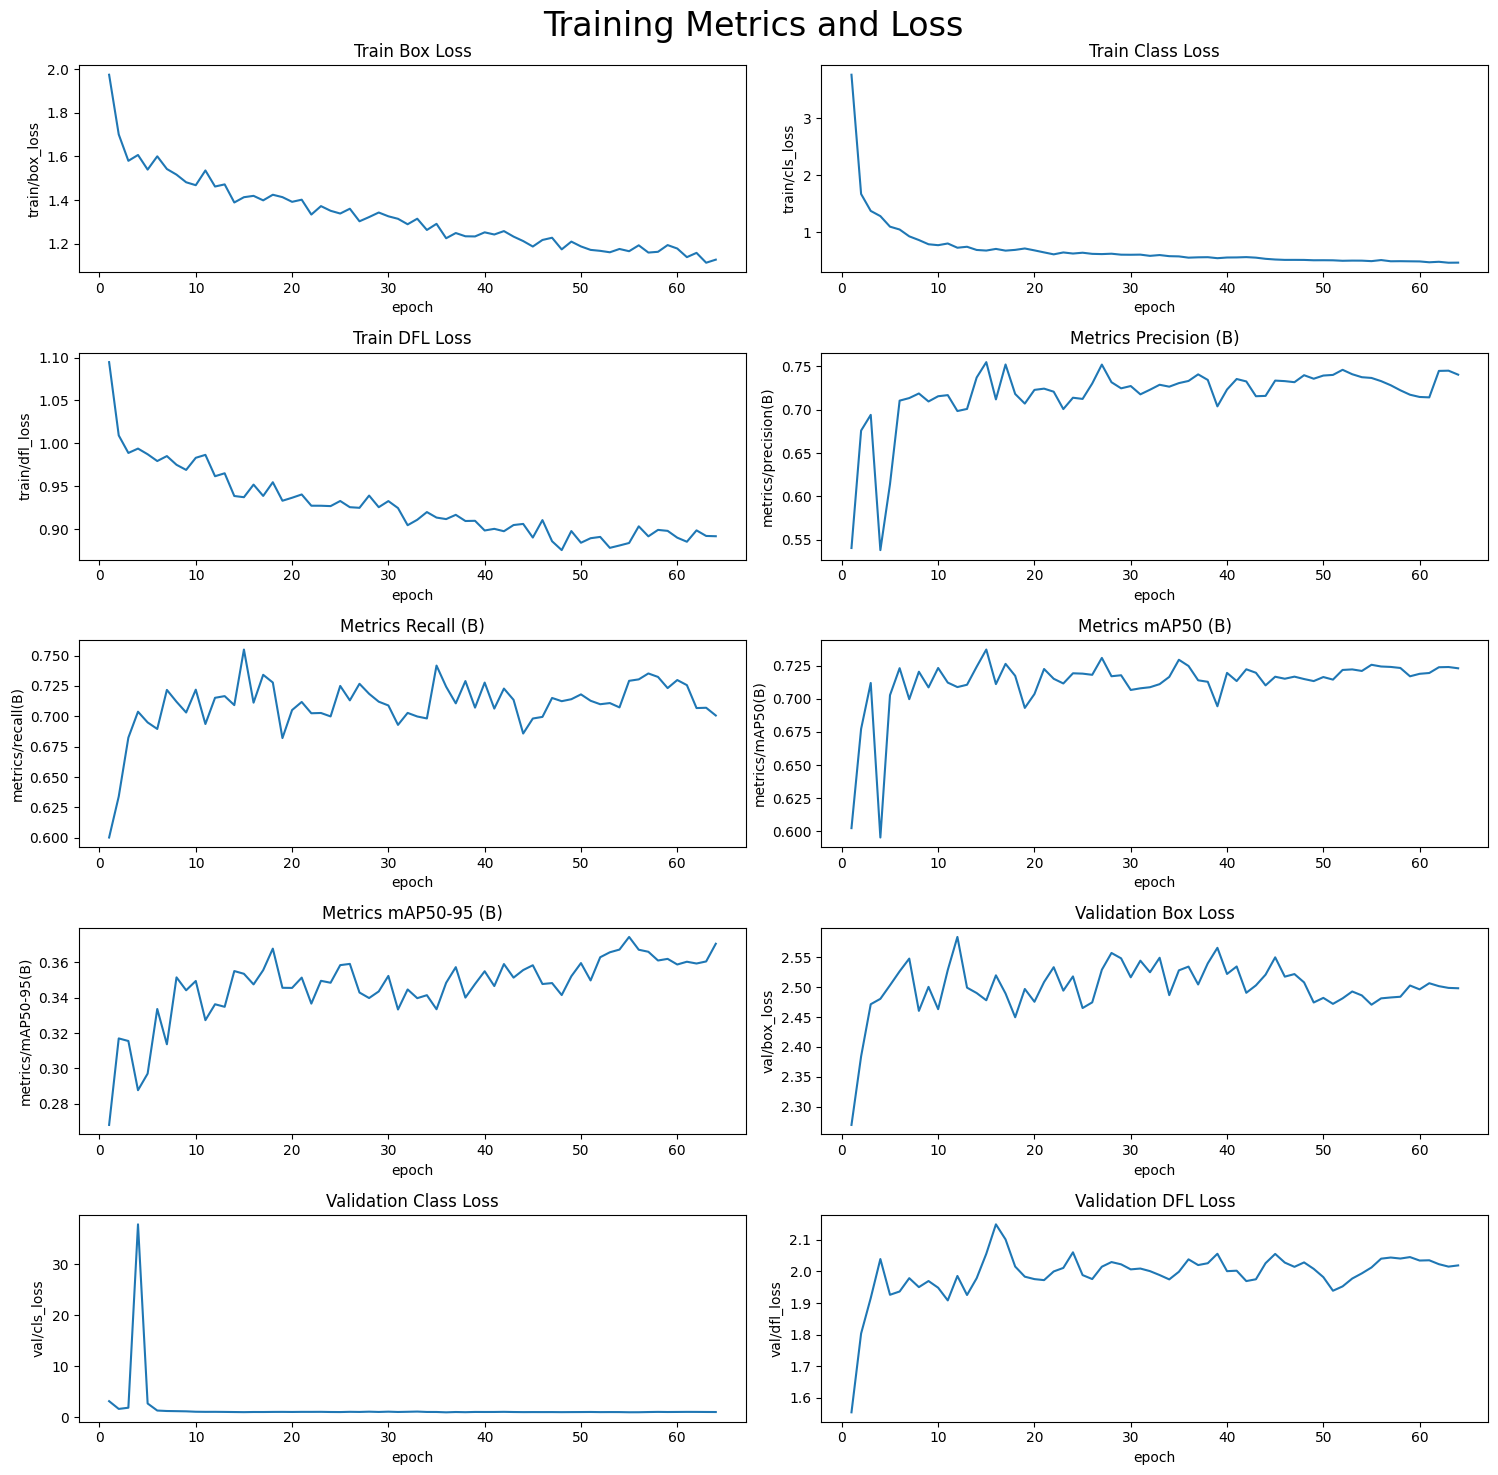

In [19]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train2/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluate model

In [27]:
%matplotlib inline
# Loading the best performing model
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68143791 parameters, 0 gradients, 257.5 GFLOPs


val: Scanning /kaggle/input/vietnam-video-frames-traffic-sign/split/test/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 468.01it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/vietnam-video-frames-traffic-sign/split/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


                   all         43        206      0.768      0.666      0.711      0.388
       Chỉ hướng đường         43          9          1          1      0.995      0.643
 Làn đường cho từng xe         43         31          1      0.774      0.887      0.558
    Cấm đi ngược chiều         43         13      0.929          1      0.995      0.505
            Cấm xe máy         43         29          1      0.759      0.879      0.491
Cấm các phương tiện quy định theo khung giờ         43         35          1      0.829      0.914      0.594
     Cấm dừng - Cấm đỗ         43         20      0.833          1      0.948      0.396
   Giới hạn tốc độ: 60         43         17      0.111      0.118     0.0706     0.0111
   Giới hạn tốc độ: 80         43         28      0.225      0.179      0.139     0.0638
                  Khác         43         24      0.816      0.333      0.573      0.232
Speed: 0.2ms preprocess, 46.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Result

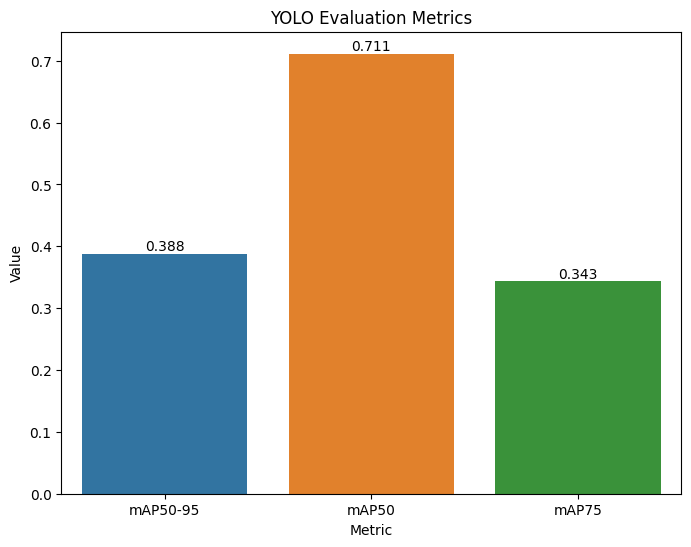

In [23]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()

# Prediction

In [24]:
# Function to perform traffic sign detect tion
def traffic_sign_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 416x736 1 Chỉ hướng đường, 1 Làn đường cho từng xe, 1 Cấm xe máy, 1 Giới hạn tốc độ: 80, 1 Khác, 86.5ms
Speed: 3.5ms preprocess, 86.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 1 Làn đường cho từng xe, 1 Cấm xe máy, 1 Cấm các phương tiện quy định theo khung giờ, 2 Cấm dừng - Cấm đỗs, 1 Giới hạn tốc độ: 60, 1 Giới hạn tốc độ: 80, 45.3ms
Speed: 3.4ms preprocess, 45.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 1 Giới hạn tốc độ: 60, 1 Giới hạn tốc độ: 80, 46.0ms
Speed: 3.2ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 1 Chỉ hướng đường, 1 Làn đường cho từng xe, 1 Cấm xe máy, 1 Khác, 45.4ms
Speed: 2.8ms preprocess, 45.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 736)


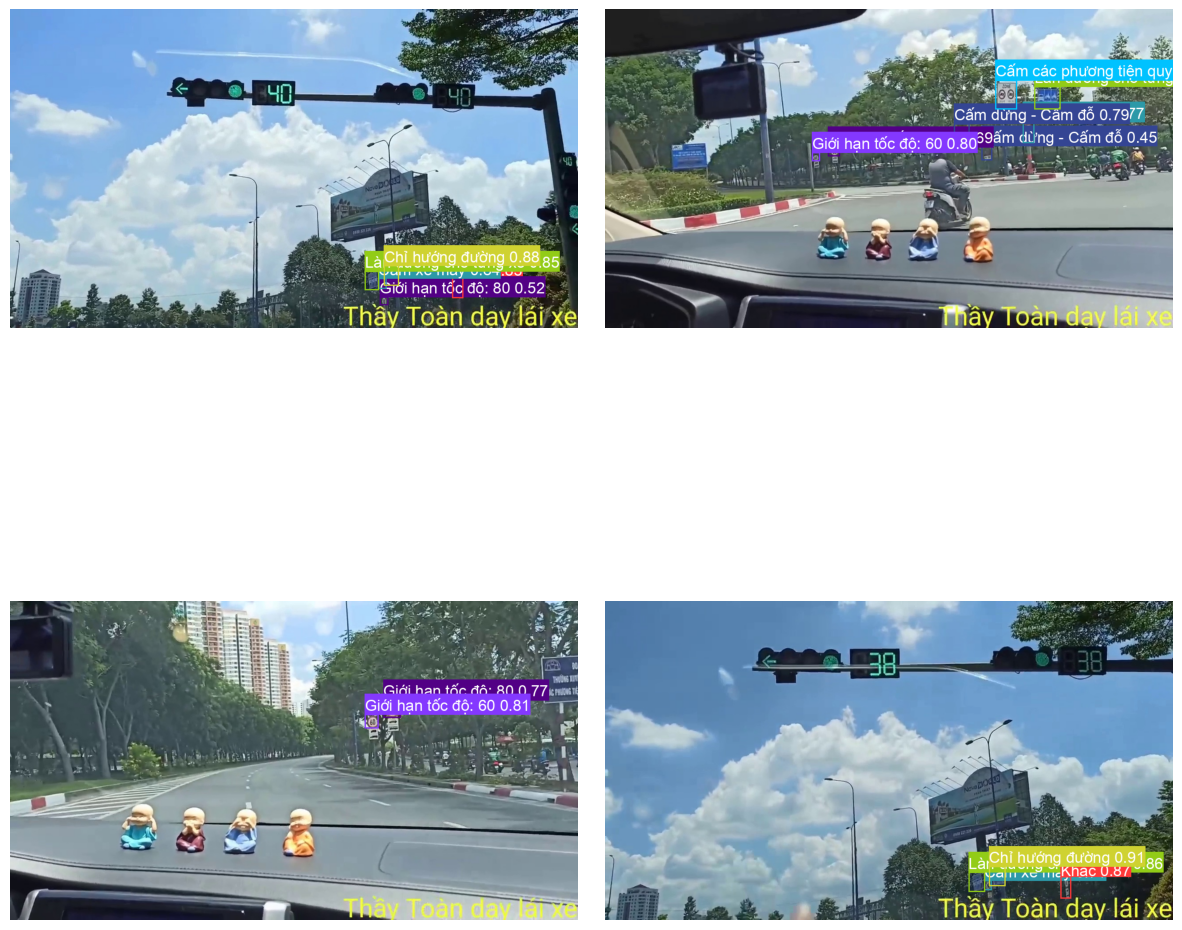

In [25]:
# Get the list of image files in test folder
image_files = os.listdir(test_imgs)

#get 9 random imgs from test
random_imgs = get_random_imgs(4, test_imgs)

rows, cols = get_row_col(len(random_imgs))

# Create a figure with subplots for each image
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(random_imgs):
    row = i // cols
    col = i % cols
    # Load the current image and run object detection
    img_path = os.path.join(test_imgs, img_file)
    detect_img = traffic_sign_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row, col].imshow(detect_img)
    axes[row, col].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)